<a href="https://colab.research.google.com/github/proppy/tinytapeout-xls-test/blob/main/notebooks/popcount.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TinyTapeOut XLS flow

```
Copyright 2022 Google LLC.
SPDX-License-Identifier: Apache-2.0
```

Run the [TinyTapeOut](https://tinytapeout.com) flow for designs using [XLS: Accelerated HW Synthesis](https://github.com/google/xls) toolkit.

In [1]:
#@title Configure WOWKI ID

WOKWI_PROJECT_ID = 339800239192932947 #@param {type:"integer"}

## Install dependencies

In [2]:
import os
import pathlib
import sys

!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
site_package_path = conda_prefix_path / 'lib/python3.7/site-packages'
sys.path.append(str(site_package_path.resolve()))
CONDA_PREFIX = str(conda_prefix_path.resolve())
PATH = os.environ['PATH']
LD_LIBRARY_PATH = os.environ.get('LD_LIBRARY_PATH', '')
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}
%env LD_LIBRARY_PATH={CONDA_PREFIX}/lib:{LD_LIBRARY_PATH}
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel litex-hub \
                        --channel main \
                        open_pdks.sky130a \
                        magic \
                        openroad \
                        netgen \
                        yosys \
                        xls
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel conda-forge \
                        tcllib gdstk pyyaml click

bin/micromamba
env: CONDA_PREFIX=/content/conda-env
env: PATH=/content/conda-env/bin:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin
env: LD_LIBRARY_PATH=/content/conda-env/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64

                                           __
          __  ______ ___  ____ _____ ___  / /_  ____ _
         / / / / __ `__ \/ __ `/ __ `__ \/ __ \/ __ `/
        / /_/ / / / / / / /_/ / / / / / / /_/ / /_/ /
       / .___/_/ /_/ /_/\__,_/_/ /_/ /_/_.___/\__,_/
      /_/

Empty environment created at prefix: /content/conda-env

                                           __
          __  ______ ___  ____ _____ ___  / /_  ____ _
         / / / / __ `__ \/ __ `/ __ `__ \/ __ \/ __ `/
        / /_/ / / / / / / /_/ / / / / / / /_/ / /_/ /
       / .___/_/ /_/ /_/\__,_/_/ /_/ /_/_.___/\__,_/
      /_/

[+] 0.0s
[+] 0.1s
litex-hub/linux-64  ⣾  
litex-hub/noarch    ⣾

## Get TinyTapeout XLS template

In [3]:
!git clone https://github.com/proppy/tinytapeout-xls-test.git

Cloning into 'tinytapeout-xls-test'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 115 (delta 54), reused 10 (delta 0), pack-reused 0
Receiving objects: 100% (115/115), 59.17 KiB | 5.38 MiB/s, done.
Resolving deltas: 100% (54/54), done.


## Update DSLX module

In [4]:
%%bash -c 'cat > tinytapeout-xls-test/src/user_module.x; interpreter_main tinytapeout-xls-test/src/user_module.x'

fn popcount(n: u8) -> u8 {
  for (i, c): (u8, u8) in u8:0..u8:8 {
    c + ((n >> i) & u8:1)
  }(u8:0)
}

#![test]
fn popcount_test() {
  let _= assert_eq(popcount(u8:0b0000_0000), u8:0);
  let _= assert_eq(popcount(u8:0b0000_0001), u8:1);
  let _= assert_eq(popcount(u8:0b1111_0000), u8:4);
  let _= assert_eq(popcount(u8:0b0101_0101), u8:4);
  let _= assert_eq(popcount(u8:0b1111_1111), u8:8);
  _
}

pub fn user_module(io_in: u8) -> u8 {
  popcount(io_in)
}

[ RUN UNITTEST  ] popcount_test
[            OK ]
[===============] 1 test(s) ran; 0 failed; 0 skipped.


## Generate verilog

In [5]:
!make -C tinytapeout-xls-test generate
!make -C tinytapeout-xls-test WOKWI_PROJECT_ID={WOKWI_PROJECT_ID} fetch
!cat tinytapeout-xls-test/src/user_module_{WOKWI_PROJECT_ID}.v

make: Entering directory '/content/tinytapeout-xls-test'
ir_converter_main --top=user_module src/user_module.x > src/user_module.ir
opt_main src/user_module.ir > src/user_module_opt.ir
codegen_main --module_name user_module_USER_MODULE_ID --use_system_verilog=false --generator=combinational src/user_module_opt.ir > src/user_module.v
make: Leaving directory '/content/tinytapeout-xls-test'
make: Entering directory '/content/tinytapeout-xls-test'
sed -e 's/USER_MODULE_ID/339800239192932947/g' src/user_module.v > src/user_module_339800239192932947.v
sed -e 's/USER_MODULE_ID/339800239192932947/g' template/scan_wrapper.v > src/scan_wrapper_339800239192932947.v
sed -e 's/USER_MODULE_ID/339800239192932947/g' template/config.tcl > src/config.tcl
echo 339800239192932947 > src/ID
make: Leaving directory '/content/tinytapeout-xls-test'
module user_module_339800239192932947(
  input wire [7:0] io_in,
  output wire [7:0] out
);
  wire [1:0] add_347;
  wire [1:0] add_349;
  wire [1:0] add_351;
  wire

## Get OpenLane

In [6]:
!git clone --depth=1 https://github.com/The-OpenROAD-Project/OpenLane

Cloning into 'OpenLane'...
remote: Enumerating objects: 466, done.
remote: Counting objects: 100% (466/466), done.
remote: Compressing objects: 100% (394/394), done.
remote: Total 466 (delta 69), reused 271 (delta 31), pack-reused 0
Receiving objects: 100% (466/466), 2.77 MiB | 10.54 MiB/s, done.
Resolving deltas: 100% (69/69), done.


## Run OpenLane Flow

In [7]:
import os
import pathlib
OPENLANE_ROOT=str(pathlib.Path('OpenLane').resolve())
PATH=os.environ['PATH']
%env PDK_ROOT={CONDA_PREFIX}/share/pdk
%env PDK=sky130A
%env STD_CELL_LIBRARY=sky130_fd_sc_hd
%env STD_CELL_LIBRARY_OPT=sky130_fd_sc_hd
%env TCLLIBPATH={CONDA_PREFIX}/lib/tcllib1.20
%env OPENLANE_ROOT={OPENLANE_ROOT}
%env PATH={PATH}:{OPENLANE_ROOT}:{OPENLANE_ROOT}/scripts
%env OPENLANE_LOCAL_INSTALL=1
%env TEST_MISMATCHES=none
%env OPENLANE_OVERRIDE_ENV=RUN_KLAYOUT=0,RUN_CVC=0
!make -C tinytapeout-xls-test HARDEN_ENV=native harden

env: PDK_ROOT=/content/conda-env/share/pdk
env: PDK=sky130A
env: STD_CELL_LIBRARY=sky130_fd_sc_hd
env: STD_CELL_LIBRARY_OPT=sky130_fd_sc_hd
env: TCLLIBPATH=/content/conda-env/lib/tcllib1.20
env: OPENLANE_ROOT=/content/OpenLane
env: PATH=/content/conda-env/bin:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/content/OpenLane:/content/OpenLane/scripts
env: OPENLANE_LOCAL_INSTALL=1
env: TEST_MISMATCHES=none
env: OPENLANE_OVERRIDE_ENV=RUN_KLAYOUT=0,RUN_CVC=0
make: Entering directory '/content/tinytapeout-xls-test'
/content/OpenLane/flow.tcl -override_env TEST_MISMATCHES=none,RUN_KLAYOUT=0,RUN_CVC=0 -design src/ -run_path runs/
OpenLane e14b1fd8c29643465e35ad4c3a16349d96bdaa21
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[INFO]: Using configuration in 'src/config.tcl'.

## Display layout

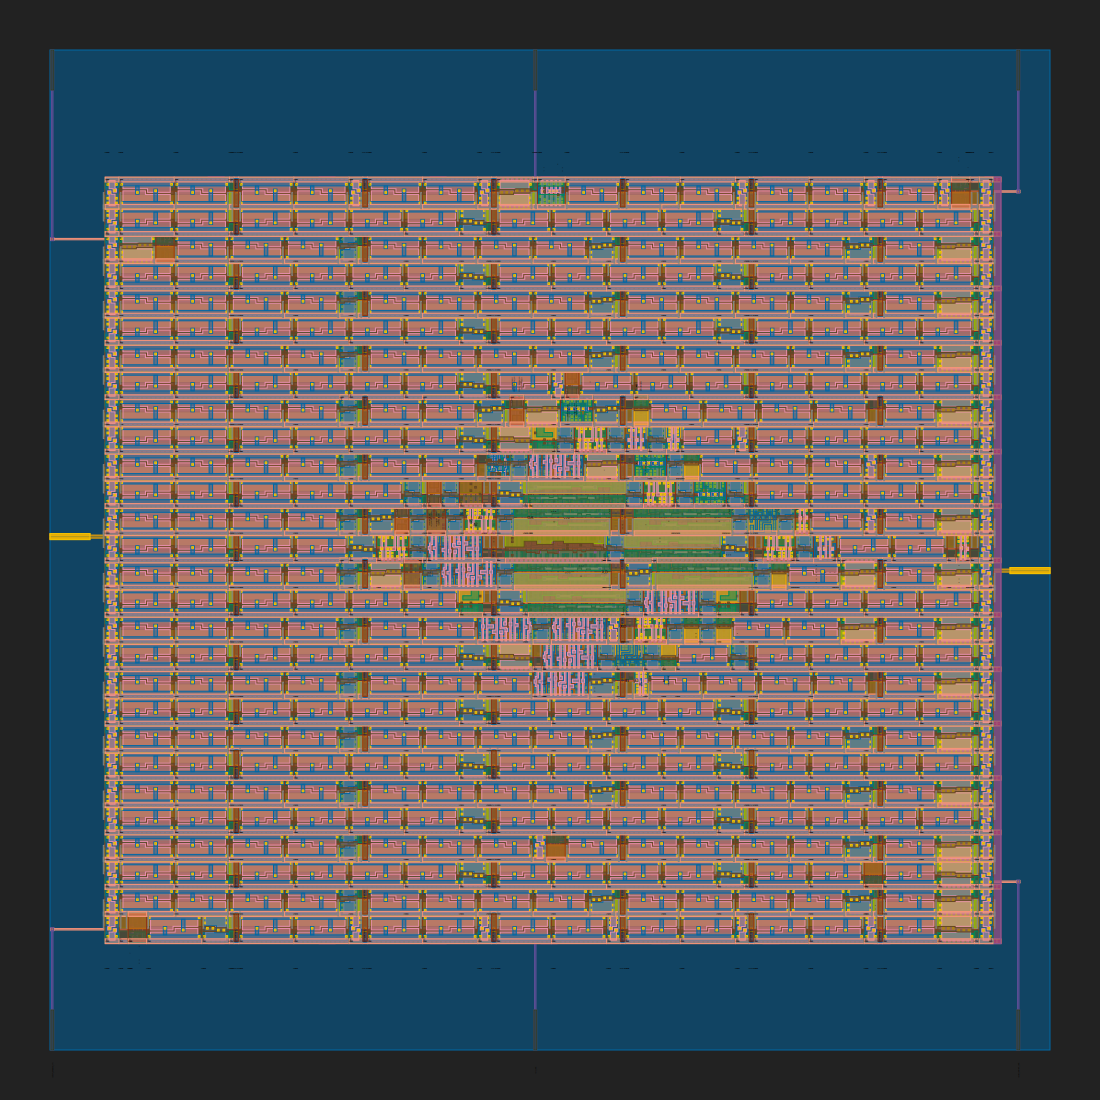

In [12]:
import pathlib
import gdstk
import IPython.display

gdss = sorted(pathlib.Path('tinytapeout-xls-test/runs').glob('*/results/final/gds/*.gds'))
library = gdstk.read_gds(gdss[-1])
top_cells = library.top_level()
top_cells[0].write_svg('user_module.svg')
IPython.display.SVG('user_module.svg')

## Dump flow report

In [13]:
import pandas as pd
import pathlib

pd.options.display.max_rows = None
final_summary_reports = sorted(pathlib.Path('tinytapeout-xls-test/runs').glob('*/reports/metrics.csv'))
df = pd.read_csv(final_summary_reports[-1])
df.transpose()

,0
design,/content/tinytapeout-xls-test/src
design_name,scan_wrapper_339800239192932947
config,RUN_2022.08.31_05.16.52
flow_status,flow completed
total_runtime,0h1m28s0ms
routed_runtime,0h1m13s0ms
(Cell/mm^2)/Core_Util,-2.222222
DIEAREA_mm^2,0.01
CellPer_mm^2,-1
OpenDP_Util,11.72
